# Intercomparison Campaigns - Interpolate Data

**Contains modified Copernicus Climate Change Service Information 2020**
under [License](https://apps.ecmwf.int/datasets/licences/copernicus/)

*Copernicus Climate Change Service (C3S) - Upper Air Data Service (2020)*

The purpose of this IPython Notebook is to demonstrate the usability of data from intercomparison campaigns.

    Author: U. Voggenberger
    Date: 09.2020
    Contact: ulrich.voggenberger [at] univie.ac.at
    License: C3S, 2020

In [1]:
import pandas
import numpy as np
import datetime
import xarray as xr
import pickle 
import matplotlib
import matplotlib.pyplot as plt
import os
from scipy.interpolate import interp1d
import sys
sys.path.append('/home/srvx11/lehre/users/a1400070/CEUAS/CEUAS/public/cds-backend/code')
import cds_eua3 as eua
eua.logging_set_level(30)
import warnings
warnings.filterwarnings("ignore")

In [2]:
plt.rcParams['figure.figsize'] = (10,10)
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

## Accessing data directly via eua - h5py:

We will interpolate pressure data to compare different sondes, which were all mounted onto the same balloon. <br>
It's not necessary to select the data with the help of 'ListProfiles.xls' - a file for mapping the data of the different sondes to one ascent. <br>
Opening all available data and searching for the matching report_id would be possible too, but slower. <br> <br>


__Consider that there is no height information matching the pressure values on early radiosondes.__ <br> <br>


We will select a reference sonde, based on the longest series of measurements.<br>
The pressure data of our reference sonde will be interpolated onto the time - minutes since the ascent start.<br>
With the resulting interpolation funktion we can get the exact moment, when the sonde were on a standard pressure level.<br>
In the second step we will get the pressure value of all the other sondes to that given time. For this process it's necessary to interpolate backwards: time onto pressure.<br>


1956-5-27T9.0:30.0


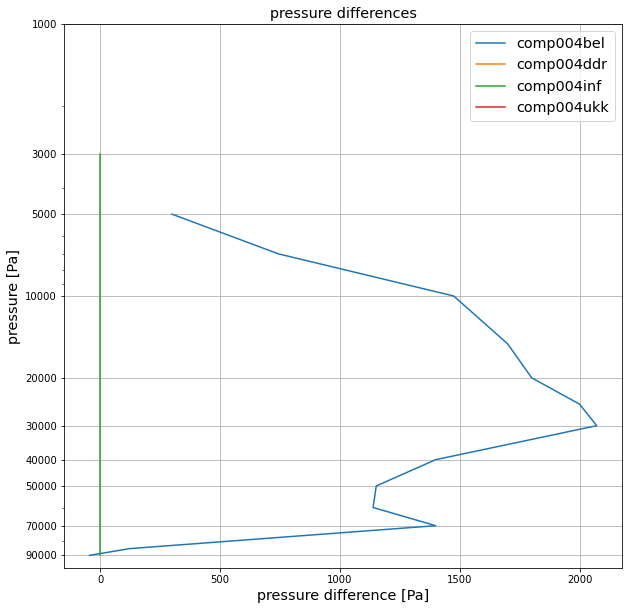

1956-5-27T15.0:0.0


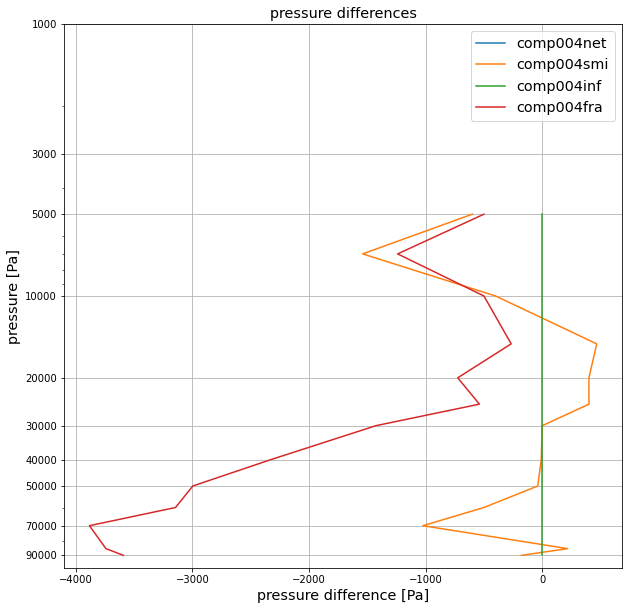

1956-5-28T9.0:0.0
1956-5-28T15.0:0.0
1956-5-28T22.0:0.0
1956-5-29T0.0:30.0
1956-5-29T9.0:0.0
1956-5-29T15.0:0.0
1956-5-29T22.0:0.0
1956-5-30T0.0:30.0
1956-5-30T9.0:0.0
1956-5-30T15.0:0.0
1956-5-30T22.0:0.0
1956-5-31T0.0:30.0
1956-5-31T9.0:0.0
1956-5-31T15.0:0.0
1956-5-31T22.0:0.0
1956-6-1T0.0:30.0
1956-6-1T9.0:0.0
1956-6-1T15.0:0.0
1956-6-1T22.0:0.0
1956-6-2T0.0:30.0
1959-6-2T15.0:0.0
1956-6-4T0.0:0.0
1956-6-4T9.0:0.0
1956-6-4T15.0:0.0
1956-6-4T22.0:0.0
1956-6-5T0.0:30.0
1956-6-5T9.0:0.0
1956-6-5T15.0:0.0
1956-6-5T22.0:0.0
1956-6-6T0.0:30.0
1956-6-6T9.0:0.0
1956-6-6T15.0:0.0
1956-6-6T22.0:0.0
1956-6-7T0.0:30.0
1956-6-7T9.0:0.0
1956-6-7T15.0:0.0
1956-6-7T22.0:0.0
1956-6-8T0.0:30.0
1956-6-8T9.0:0.0
1956-6-8T15.0:0.0
1956-6-8T22.0:0.0
1956-6-9T9.0:0.0
1956-6-9T22.0:0.0
1956-6-11Tnan:nan
1956-6-11Tnan:nan
1956-6-11Tnan:nan
1956-6-12Tnan:nan
1956-6-12Tnan:nan
1956-6-12Tnan:nan
1956-6-13Tnan:nan
1956-6-13Tnan:nan
1956-6-14Tnan:nan
1956-6-14Tnan:nan
1956-6-14Tnan:nan
1956-6-1Tnan:nan
1956-6-3

In [3]:
comp = 'COMP004'
ref = 'comp003ger'

file = r'/raid60/scratch/leo/scratch/RI/Pangaea/COMP/' +comp+ '/' +comp+ '_ListProfiles.xls'
df = pandas.read_excel(file)

file = r'/raid60/scratch/leo/scratch/RI/Pangaea/nc/mapping.tsv'
tsv_read = pandas.read_csv(file, sep='\t')
tsv_read['Comparison'][0] , tsv_read['File'][0]

# get each timeseries from one ascent
comps = []
for i in df.drop_duplicates(subset=['id_ascent'])['id_ascent']:
    comps.append(df[df['id_ascent'] == i])

# iterate over all ascents (groups of timeseries)
sond_all = []
pres_all = []
show = 3 # show only the first two plots.
sondtypes = []
for j in comps:
    print(str(np.array(j.yr)[0])+'-'+str(np.array(j.mo)[0])+'-'+str(np.array(j.day)[0])+'T'+str(np.array(j.hour_cet)[0])+':'+str(np.array(j['min'])[0]))
    show -= 1
    sondelist = np.array(j.ri_name)
    if(len(j) <= 1):
#         print('nothing to compare - one ascent or less')
        continue
#     -
#     iterate over each sensor teamseries in the ascent group
#     -
    temp = []
    pres = []
    time = []
    tempsondes = []
    for i in range(len(j)):
#         iterate through the tsv
        for k in range(len(tsv_read)):
#         find the right .nc file throug the sensor name
            if(tsv_read['Comparison'][k] == j.iloc[i]['ri_name']):
                ncfilename = tsv_read['File'][k]
                break
#         open data and extract only the wanted ascents       
        data = eua.CDMDataset('/raid60/scratch/leo/scratch/RI/Pangaea/nc/'+ncfilename)

        # selection: creats a slice to read the data, 
        selection = data.read_observed_variable(85, 
                            plevs = eua.std_plevs*100, 
                            times = None,
                            return_index=True
                           )

        x = data.profile_to_dataframe('observations_table', 
                                      ['observation_value', 'date_time', 'z_coordinate', 'observed_variable', 'report_id'],
                                      np.where(selection[1])[0],
                                      date_is_index=True)
        
        x = x[x.observed_variable == 85]
        ida = ncfilename[:15] + '-' + j.iloc[i]['id_ascent'][-3:]
        try:
            x = x[x['report_id'] == ida]
        except:
#             print('missing Data for: ' + ida + ' in ' + ncfilename)
            pass

        temp.append(np.array(x.observation_value))
        time.append(np.array(x.date_time))
        pres.append(np.array(x.z_coordinate))
#     -
#     Interpolation:
#     forward interpolation pressure on time:
#     select longest dataseries as reference
#     -
    try:
        # for the longest dataset as the reference:
        referencepres = max(pres, key=len)
        referencetime = max(time, key=len)
#         # for a specific dataset as the reference:
#         referencepres = np.array(pres, dtype='object')[np.array(sondelist, dtype='object') == ref][0]
#         referencetime = np.array(time, dtype='object')[np.array(sondelist, dtype='object') == ref][0]
        f = interp1d( (referencepres), referencetime)
        pressure_list = [3000., 5000., 7000., 10000., 15000., 20000., 25000., 30000., 40000., 50000., 60000., 70000., 85000., 90000.]
        pres_delta = []
        return_sondlist = []
        for j in range(len(pres)):
            try:
                sondtypes.append(sondelist[j])
                return_sondlist.append(sondelist[j])
                g = interp1d( time[j], (pres[j]))
                pres_delta.append([])
                for i in range(len(pressure_list)):
                    # backward interpolation time on pressure:
                    try:
                        pres_delta[j].append(pressure_list[i] - (float((g(f((pressure_list[i])))))))
                    except:
                        pres_delta[j].append(np.nan)
            except:
                pres_delta.append([np.nan]*len(pressure_list))
                return_sondlist.append(np.nan)

        pres_all.append(pres_delta)
        sond_all.append(return_sondlist)
    #     -
    #     plotting:
    #     -
        if(show<=0):
            pass
        else:
            fig, (ax1) = plt.subplots(1)
            yplevs = np.array([10,30,50,100,200,300,400,500,700,900])*100.
        #     -
            for r in range(len(pres_delta)):
                ax1.semilogy(pres_delta[r], pressure_list)
            ax1.set(xlabel ='pressure difference [Pa]', ylabel='pressure [Pa]', title='pressure differences', )
            ax1.set_yticks(ticks=yplevs)
            ax1.set_yticklabels(map("{:.0f}".format,yplevs),rotation='horizontal')
            ax1.set_ylim(100000,1000)
            ax1.legend(sondelist, loc='best')
            ax1.grid()
            plt.show()

    except:
        pass

## Generating Mean Pressure Differences:

It would be interesting to see the mean pressure differences on the standard levels. <br>
For this task we summ up the data of all ascents und divide it by the number of ascents. <br>


In [4]:
p = np.array(pres_all, dtype='object')
s = np.array(sond_all, dtype='object')
st = np.unique(sondtypes)
means = []
for i in range(len(st)):
    add = []
    print(st[i])
    for j in range(len(p)):
        for k in range(len(p[j])):
            if(s[j][k] == st[i]):
                add.append(np.array(p[j][k], dtype='object'))
    means.append(np.array(add, dtype='object'))
means = np.array(means, dtype='object')

comp004bel
comp004dbr
comp004ddr
comp004fin
comp004fra
comp004inc
comp004inf
comp004jap
comp004net
comp004pol
comp004rus
comp004smi
comp004ukk
comp004usa


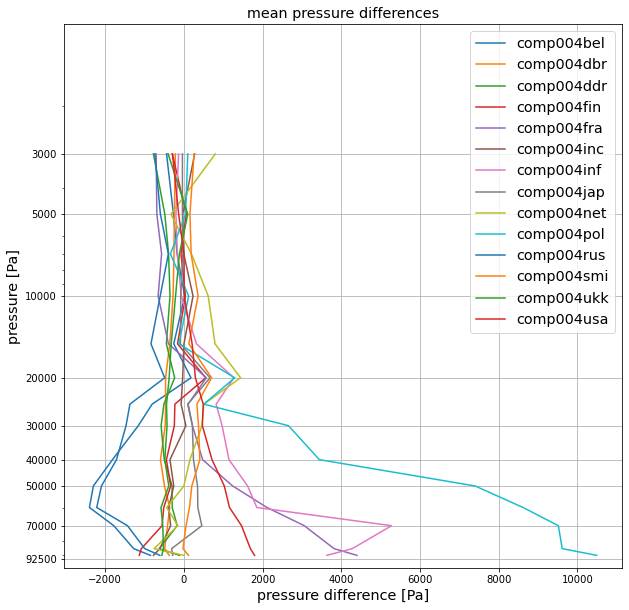

In [6]:
fig, (ax1) = plt.subplots(1)
yplevs = np.array([30,50,100,200,300,400,500,700,925])*100.
#     -
for i in range(len(means)):
    ax1.semilogy(np.nanmean(means[i], axis = 0), pressure_list)
ax1.set(xlabel ='pressure difference [Pa]', ylabel='pressure [Pa]', title='mean pressure differences', )
ax1.set_yticks(ticks=yplevs)
ax1.set_yticklabels(map("{:.0f}".format,yplevs),rotation='horizontal')
ax1.set_ylim(100000,1000)
ax1.legend(st, loc='best')
ax1.grid()
plt.show()